In [12]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV


from sklearn.preprocessing import StandardScaler

df = pd.read_parquet('data/processed_dataset.parquet')

In [13]:
def get_predictions(model, X_test):
    predictions_prob = model.predict_proba(X_test)
    predictions = model.predict(X_test)
    return predictions, predictions_prob

# Make DataFrame
def make_df(predictions_prob, predictions, test, season):
    predictions_df = pd.DataFrame({
        'Season': season,
        'Date': test['Date'].values,
        'Home_Team': test['TEAM_NAME'].values,
        'Home_Prob': predictions_prob[:, 1].flatten(),
        "Home_Binary": predictions.flatten(),
        'Away_Team': test['TEAM_NAME.1'].values,
        'Away_Prob': (1 - predictions_prob[:, 1]).flatten(),
        'Away_Binary': (1 - predictions).flatten(),
        'Home_Team_Win': test['Home-Team-Win'].values
    })
    return predictions_df

def get_accuracy(predictions, test, season):
    return pd.DataFrame({
        'Season': season,
        'Accuracy': round(accuracy_score(test['Home-Team-Win'], predictions), 4),
        'F1': round(f1_score(test['Home-Team-Win'], predictions), 4),
        'AUC': round(roc_auc_score(test['Home-Team-Win'], predictions), 4)
    }, index=[0])

def backtest_ensemble(data, predictors, start=3, step=1):
    seasons = sorted(data['Season'].unique())
    prob_dfs = []
    acc_dfs = []
    
    for i in range(start, len(seasons), step):
        train = data[data['Season'] < seasons[i]]
        test = data[data['Season'] == seasons[i]]
        
        # Initialize models fresh for each iteration
        lr_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(max_iter=1000, solver='saga', random_state=42, n_jobs=-1, C=0.1, penalty='l2'))
        ])
        
        rf = RandomForestClassifier(
            random_state=42, 
            n_jobs=-1, 
            n_estimators=600, 
            max_depth=8
        )
        
        xgb = XGBClassifier(
            objective='binary:logistic', 
            n_jobs=-1, 
            random_state=42, 
            learning_rate=0.01, 
            n_estimators=300, 
            max_depth=3
        )
        
        # Create and fit individual models
        lr_pipeline.fit(train[predictors], train['Home-Team-Win'])
        rf.fit(train[predictors], train['Home-Team-Win'])
        xgb.fit(train[predictors], train['Home-Team-Win'])
        
        # Get probabilities from each model
        lr_proba = lr_pipeline.predict_proba(test[predictors])
        rf_proba = rf.predict_proba(test[predictors])
        xgb_proba = xgb.predict_proba(test[predictors])
        
        # Average the probabilities (soft voting)
        predictions_prob = (lr_proba + rf_proba + xgb_proba) / 3
        predictions = (predictions_prob[:, 1] >= 0.5).astype(int)
        
        prob_dfs.append(make_df(predictions_prob, predictions, test, seasons[i]))
        acc_dfs.append(get_accuracy(predictions, test, seasons[i]))
    
    return pd.concat(prob_dfs), pd.concat(acc_dfs)



# Update predictors list
meta_cols = ['Season', 'Date', 'Date.1', 'OU-Cover', 'OU', 'Home-Team-Win', 'TEAM_NAME', 'TEAM_NAME.1', 'index']
predictors = [col for col in df.columns if col not in meta_cols]

# Run the backtest
prob_df, acc_df = backtest_ensemble(df, predictors, start=4, step=1)


In [14]:
acc_df

,Season,Accuracy,F1,AUC
0,2016,0.6432,0.7170,0.6168
0,2017,0.6551,0.7273,0.6281
0,2018,0.6582,0.7233,0.6364
0,2019,0.6597,0.7206,0.6446
0,2020,0.6195,0.6933,0.6027
0,2021,0.6435,0.7065,0.6288
0,2022,0.6222,0.6878,0.6041
0,2023,0.6494,0.7106,0.6349


NameError: name 'acc_df' is not defined

# Plotting

In [15]:
from sklearn.metrics import roc_curve


def plot_calibration(prob_df):
    true_prob, pred_prob = calibration_curve(prob_df['Home_Team_Win'], prob_df['Home_Prob'], n_bins=10)  
    plt.figure(figsize=(8, 5))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(pred_prob, true_prob, marker='.')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.show()
       
    
def plot_roc_curve(prob_df):
    fpr, tpr, _ = roc_curve(prob_df['Home_Team_Win'], prob_df['Home_Prob'])
    roc_auc = auc(fpr, tpr)
    
    
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

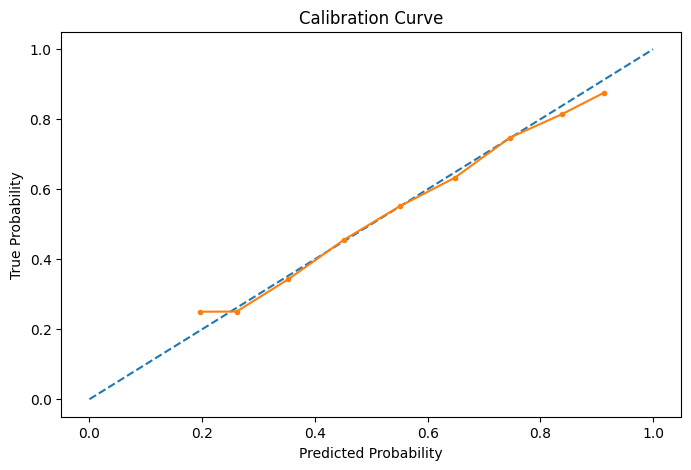

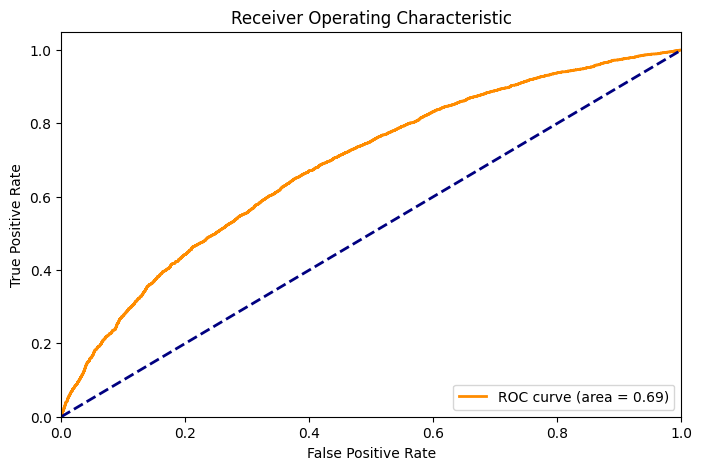

In [16]:
plot_calibration(prob_df)
plot_roc_curve(prob_df)